PROJEKTAS

Random Forest XGBoost Naive Bayes CatBoost  methods.
Each method has to be analyzed in depth (errors, hyperparameters and algorithm behavior, etc.). 
Pastraipa apie 2 naujus ( matematinis background).
it also must contain no less than 2 non trivial questions answered using the methods.
Parašyt kuris modelis kurio.


Non Trivial questions:
1. Does the person personal qualities (not credit history, money) affect the loan receival?
2. How do the models classify the "rich fails", that have huge income but defaulted previous loans?
3. Which feature affects the denial of a loan the most?


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

df = pd.read_csv('loan_data.csv')
df.columns, df.dtypes

(Index(['person_age', 'person_gender', 'person_education', 'person_income',
        'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
        'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
        'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
       dtype='object'),
 person_age                        float64
 person_gender                      object
 person_education                   object
 person_income                     float64
 person_emp_exp                      int64
 person_home_ownership              object
 loan_amnt                         float64
 loan_intent                        object
 loan_int_rate                     float64
 loan_percent_income               float64
 cb_person_cred_hist_length        float64
 credit_score                        int64
 previous_loan_defaults_on_file     object
 loan_status                         int64
 dtype: object)

In [52]:
balance  = df['loan_status'].value_counts(normalize=True)*100
missing = df.isnull().sum()

print("Loan Status Balance (%):\n", balance)
print("\nMissing Values:\n", missing)

Loan Status Balance (%):
 loan_status
0    77.777778
1    22.222222
Name: proportion, dtype: float64

Missing Values:
 person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


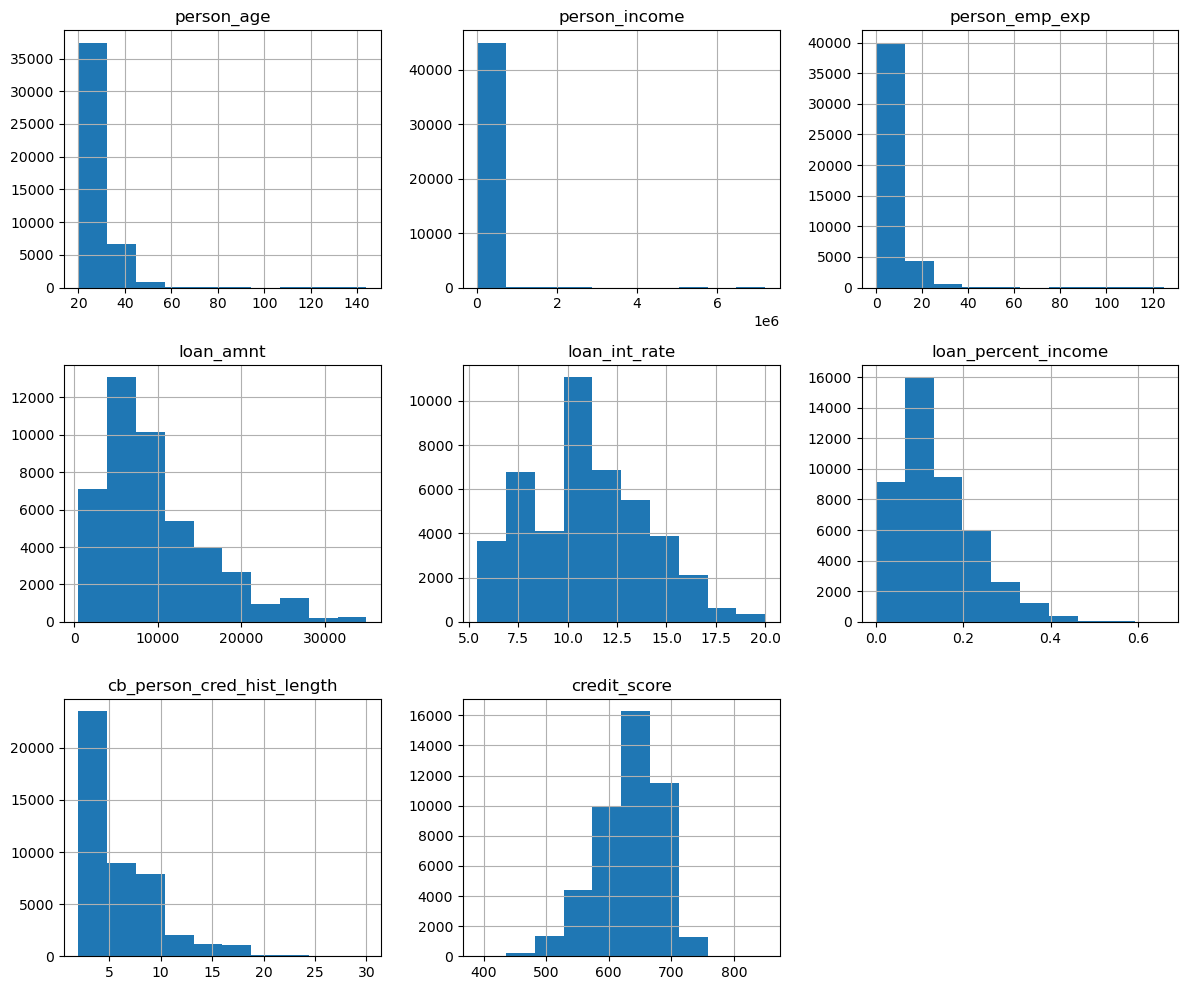

In [53]:
# histograms for each numeric column in one figure
number_variables = df.select_dtypes(include=[np.number])
number_variables.drop(columns=['loan_status'], inplace=True, errors='ignore')
number_variables.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()


1. NAIVE BAYES: normalumo nelabai tenkina didzioji dalis, nebent loan_int_rate ir credit score. Reikia transformuoti duomenis, kad būtų normalūs. 
pvz:

df['loan_amnt'] = df['loan_amnt'].apply(lambda x: np.log(x))

df['loan_amnt'] = df['loan_amnt'].apply(lambda x: np.log(x))

df['person_emp_exp'] = df['person_emp_exp'].apply(lambda x: np.log(x) if x > 0 else 0)

df['person_income'] = df['person_income'].apply(lambda x: np.log(x) if x > 0 else 0)

cb_person_cred_hist_length normalumo neišgausi jau.

2. KNN: Skalės labai skirtingos tarp kintamųjų, reiks standartizuoti, nes KNN reikšmę skirs tik turintiems dideles skales. MinMax scaler geriausia.
Kitiem modeliam šito nereikia.

Text(0.5, 1.0, 'Correlation Matrix')

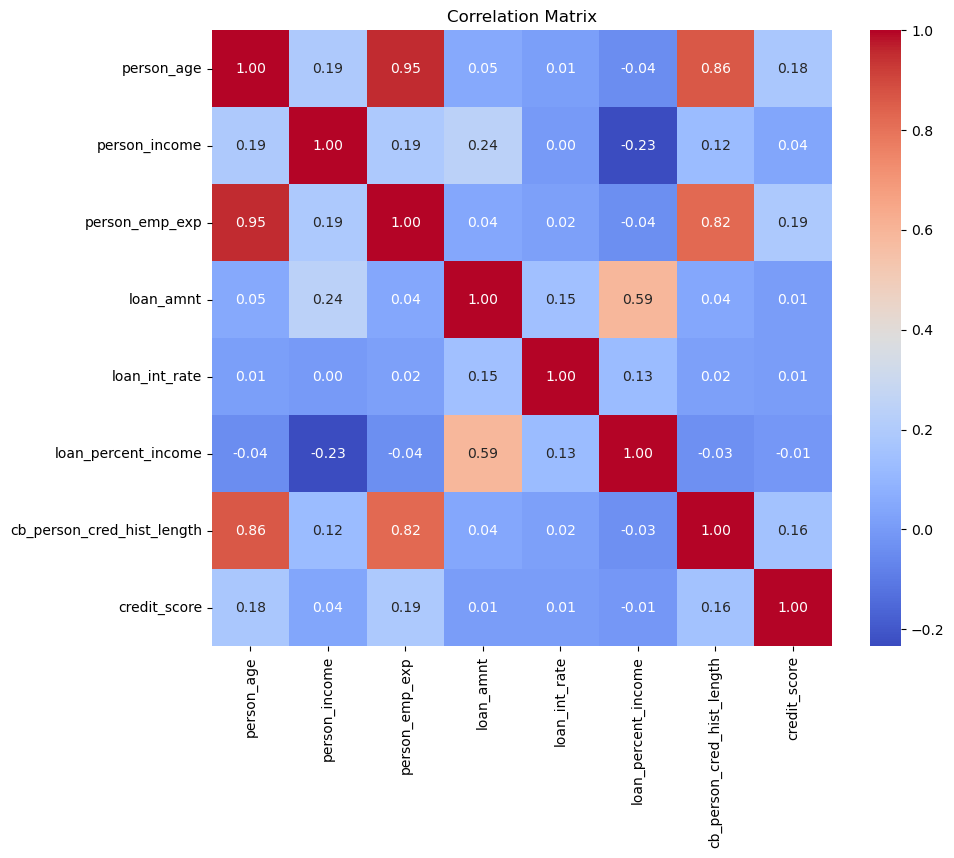

In [39]:
# correlation matrix
import seaborn as sns
corr = number_variables.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')

1. Naive Bayes: Didelė koreliacija tarp cb_person_cred_hist_lenght (kiek metų žmogaus kredito istorijos yra) koreliuoja su žmogaus amžiumi. Reikia Bayesui naikinti vieną iš šių požymių. Taip pat person_emp_exp ir cb_person_cred_hist_length, žmogaus darbo patirtis ir kredito istorijos ilgis. Logiška, nes kuo ilgiau žmogus dirbo, tuo didesnę kredito istoriją turi. Irgi reikia naikinti vieną iš jų. Tas pats su cb_person_cred_hist_lenght ir person_age.
2. KNN: Reiktų irgi mažinti koreliaciją.

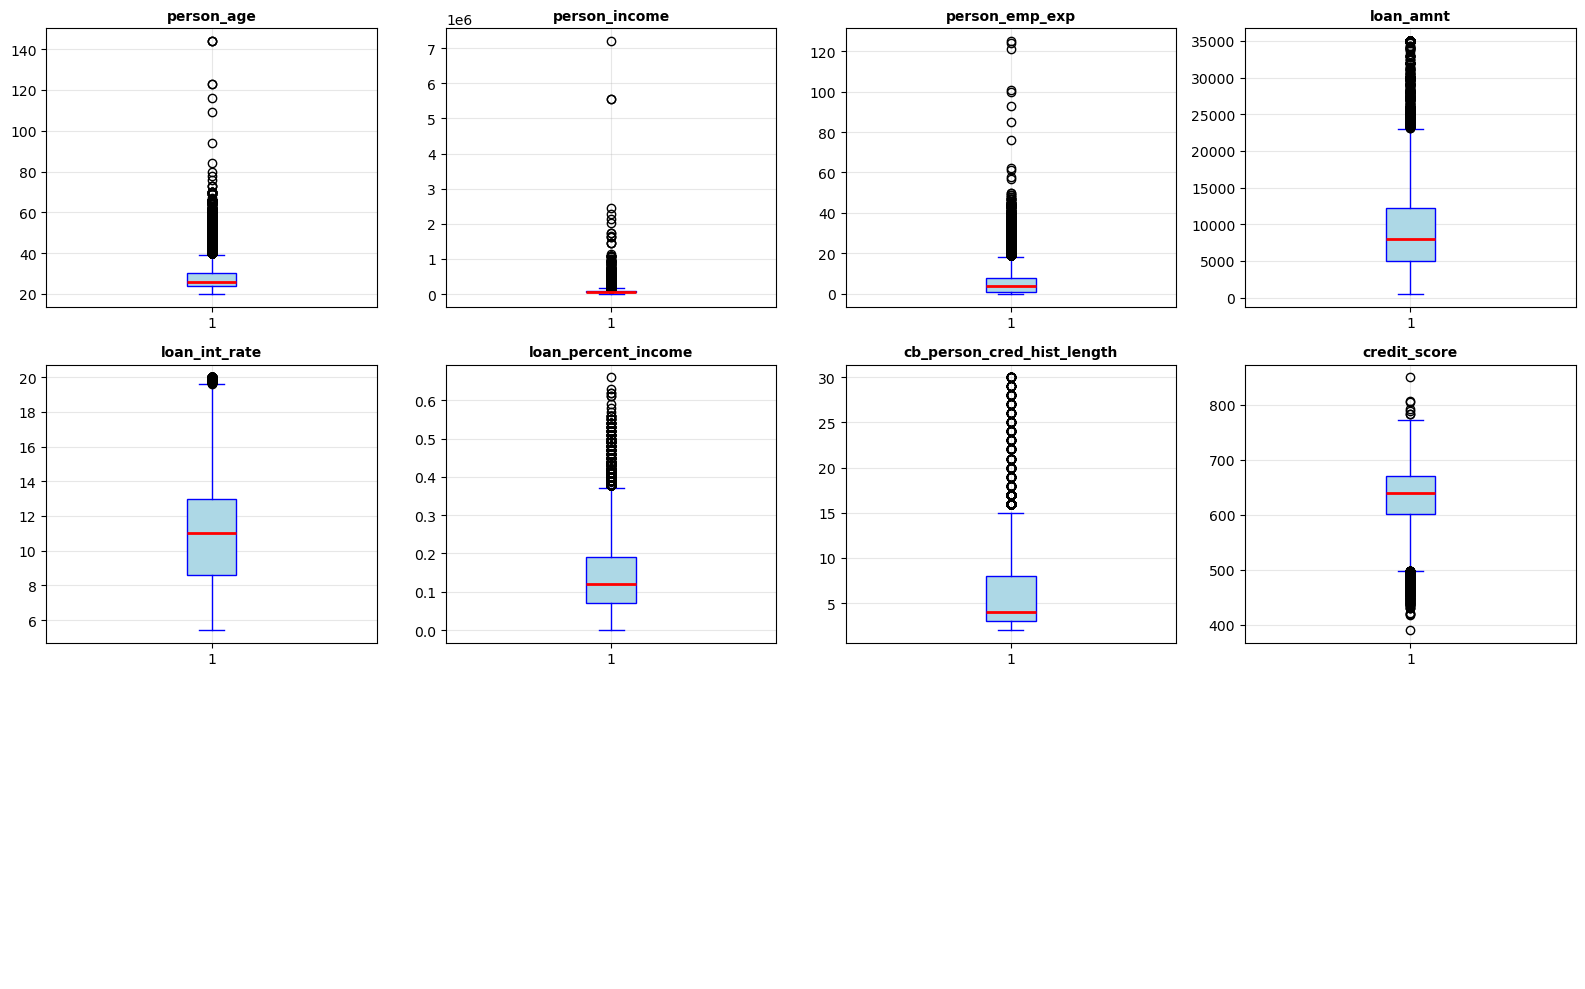

In [40]:
# box plots for numeric variables
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.ravel()

for idx, column in enumerate(number_variables.columns):
    axes[idx].boxplot(number_variables[column].dropna(), vert=True, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='blue'),
                      medianprops=dict(color='red', linewidth=2),
                      whiskerprops=dict(color='blue'),
                      capprops=dict(color='blue'))
    axes[idx].set_title(column, fontsize=10, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

# Hide any unused subplots
for idx in range(len(number_variables.columns), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

Reikia naikinti grubius outlierius KNN

In [47]:
categorical_variables = df.select_dtypes(include=['object'])
categorical_variables.nunique()

person_gender                     2
person_education                  5
person_home_ownership             4
loan_intent                       6
previous_loan_defaults_on_file    2
dtype: int64

KNN ir Random Forest: Kategorijas reiks hot-encode, tai jei bus labai daug stulpelių, gali gadinti KNN atstumus arba per daug gilūs RF medžiai.
KNN: weights='distance'
Naudoti SMOTE KNN ir Random Forest, kuris atbalansuos dataseto klases.
XGBoost naudoti sample_pos_weight,
Random Forest: class_weight='balanced'.
Naive Bayes priors modifikuoti, kad klasės turėtų tokius pat svorius.

## Random Forest modelio kūrimas, atsakymas į klausimą:
Which feature affects the denial of a loan the most?

Training Random Forest...
Predicting...
Predicting...

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      7000
           1       0.78      0.88      0.83      2000

    accuracy                           0.92      9000
   macro avg       0.87      0.90      0.89      9000
weighted avg       0.92      0.92      0.92      9000


--- Confusion Matrix ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      7000
           1       0.78      0.88      0.83      2000

    accuracy                           0.92      9000
   macro avg       0.87      0.90      0.89      9000
weighted avg       0.92      0.92      0.92      9000


--- Confusion Matrix ---


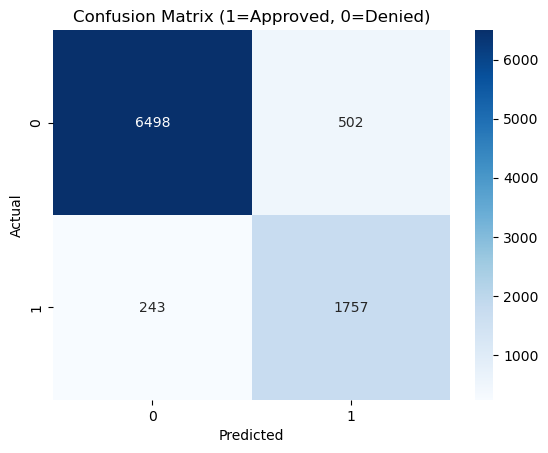

C:\Users\slefe\AppData\Local\Temp\ipykernel_31884\174810612.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


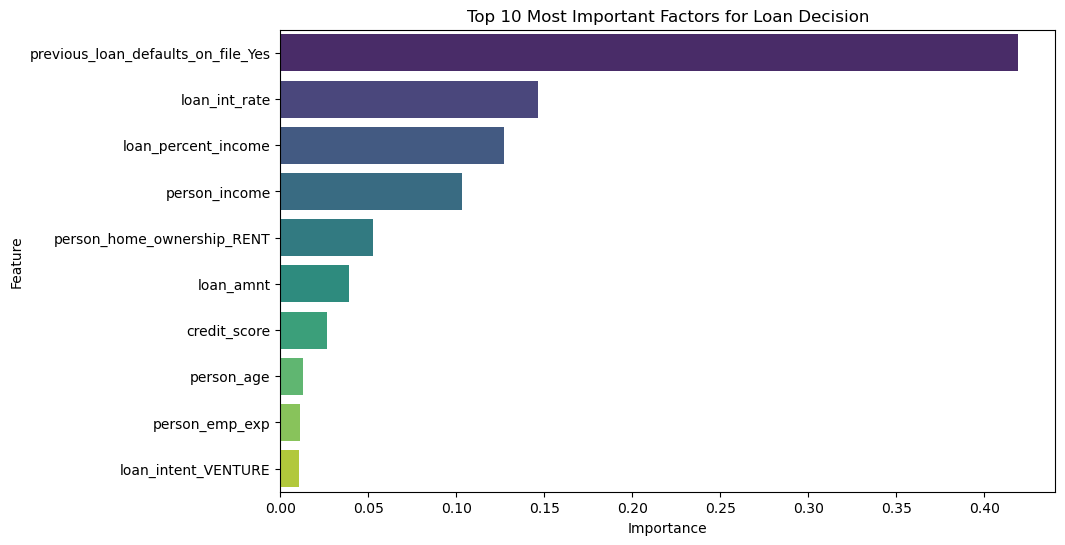

In [93]:
categorical_names =categorical_variables.columns
number_names = number_variables.columns
target = 'loan_status'

X = df.drop(target, axis=1)
y = df[target]

# Split Data (Stratify ensures we keep the same ratio of defaults in train and test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cat_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, categorical_names)
    ],
    remainder='passthrough'  # This passes through numeric columns unchanged
)

rf_model = RandomForestClassifier(
    n_estimators=400,           # Number of trees
    max_depth=30,               # Prevents the tree from getting too complex (overfitting)
    min_samples_leaf=7,         # Requires at least 7 people in a leaf to make a decision
    class_weight='balanced',    # CRITICAL: Fixes the imbalance (Approved vs Denied)
    random_state=42,
    n_jobs=-1                   # Uses all computer cores to speed up training
)

# E. Stick it all together
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

print("Training Random Forest...")
clf.fit(X_train, y_train)

print("Predicting...")
y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test) # Probability of Default

# ---------------------------------------------------------
# 4. EVALUATE PERFORMANCE
# ---------------------------------------------------------
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (1=Approved, 0=Denied)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Get categorical feature names after encoding
categorical_feature_names = list(clf.named_steps['preprocessor']
                                   .named_transformers_['cat']
                                   .named_steps['encoder']
                                   .get_feature_names_out(categorical_names))
# Combine: categorical features first (from transformers), then numeric (from remainder='passthrough')
feature_names = categorical_feature_names + number_names.tolist()
# Get importance values from the model
importances = clf.named_steps['classifier'].feature_importances_

# Create a DataFrame to plot
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title('Top 10 Most Important Factors for Loan Decision')
plt.show()

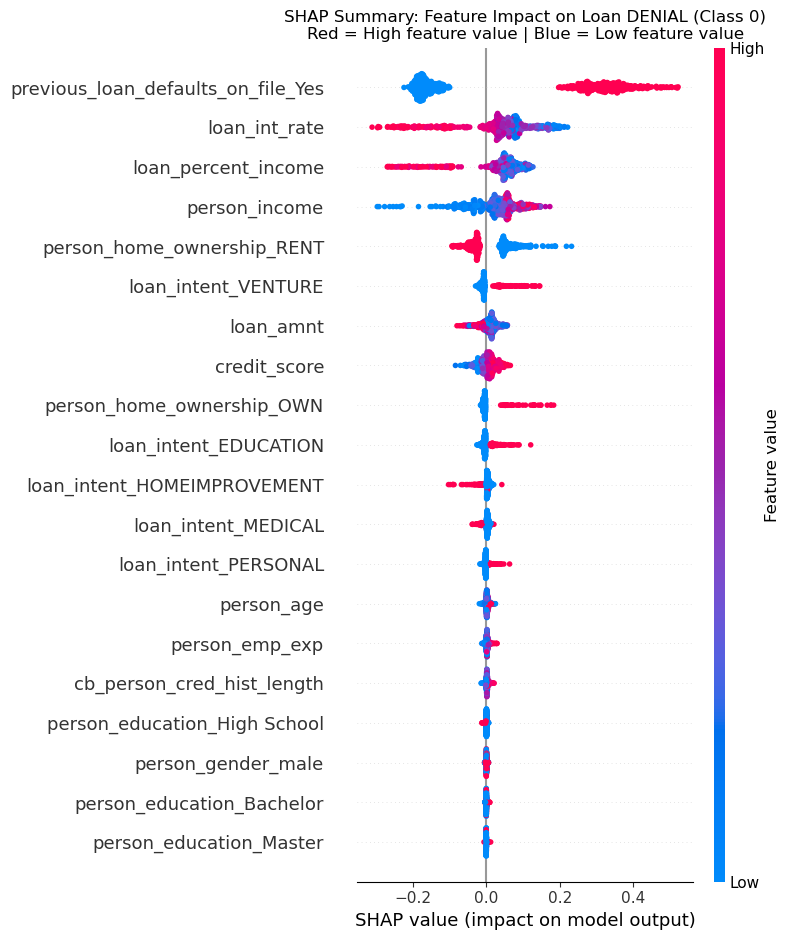

In [95]:
import shap

# Transform the test data using the preprocessor
X_test_transformed = clf.named_steps['preprocessor'].transform(X_test)

# Create SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(clf.named_steps['classifier'])

# Calculate SHAP values (use a sample for faster computation)
sample_size = min(700, X_test_transformed.shape[0])
X_sample = X_test_transformed[:sample_size]
shap_values = explainer.shap_values(X_sample)

# Handle different SHAP output formats - for class 0 (Denied)
if isinstance(shap_values, list):
    shap_values_class0 = shap_values[0]  # Class 0 = Denied
elif len(shap_values.shape) == 3:
    shap_values_class0 = shap_values[:, :, 0]
else:
    shap_values_class0 = shap_values

# --- SHAP Summary Plot (Beeswarm) - Shows direction AND magnitude ---
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_class0, X_sample, feature_names=feature_names, show=False, max_display=20)
plt.title('SHAP Summary: Feature Impact on Loan DENIAL (Class 0)\nRed = High feature value | Blue = Low feature value', fontsize=12)
plt.tight_layout()
plt.show()

Išvada:
1. Modelio tikslumas gana didelis, tačiau recall paskolos patvirtinimo klasei yra mažesnis, tai galėtų būti problema, nes bankui geriau apsidrausti ir spėti, kad paskolos yra geriau neduoti, nei išduoti rizikingai. 
2. Svarbiausi požymiai yra praeities paskolos negrąžinimas ir paskolos palūkanų norma. Iš SHAP analizės matoma, kad kategorinis kintamasis previous_loan_defaults_on_file_YES, turėdamas reikšmę 1, labai stipriai stumia modelį, kad atmesti paskolos prašymą. Tai reiškia, kad modelis daugiausiai dėmesio suteikia, ar žmogus yra negrąžinęs paskolos praeityje. Kai reikšmė 0, modelis žmogų vertina teigiamai, t.y. stumia rezultatą į teigiamą paskolos išdavimo pusę.
3. loan_int_rate yra antras svarbiausias požymis modeliui. Aukšta palūkanų norma stumia modelį į paskolos patvirtinimo pusę, tuo metu maža palūkanų norma mažina tikimybę gauti paskolą. Tai taip pat yra logiška, bankui labiau apsimoka patvirtinti tokią paskolą, todėl tai yra skatinamasis požymis, kai jo reikšmė didėja.